# **Berin & Gunita - Capstone Project**

## Lifestyle and Learning – Predicting Student Performance

**Research Question:**

1.   Which lifestyle habits are most correlated with academic performance?
2.   Can students be grouped into distinct lifestyle-based clusters, and how does academic performance vary across these groups?
3. To what extent can machine learning models accurately predict student performance or classify students into performance levels based on their lifestyle habits?

# I. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report, silhouette_score

# Upload CSV file
from google.colab import files
import io

import warnings
warnings.filterwarnings('ignore')

# II. Load Dataset

In [2]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))
df.head()

Saving student_habits_performance(in).csv to student_habits_performance(in).csv


,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


# III. Data Pre-processing

In [3]:
# Show missing values in table format before handling
missing_before = df.isnull().sum().reset_index()
missing_before.columns = ['Column', 'Missing Before']
print("Missing values before handling:")
display(missing_before)

# Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

# Show missing values in table format after handling
missing_after = df.isnull().sum().reset_index()
missing_after.columns = ['Column', 'Missing After']
print("Missing values after handling:")
display(missing_after)

Missing values before handling:


,Column,Missing Before
0,student_id,0
1,age,0
2,gender,0
3,study_hours_per_day,0
4,social_media_hours,0
5,netflix_hours,0
6,part_time_job,0
7,attendance_percentage,0
8,sleep_hours,0
9,diet_quality,0


Missing values after handling:


,Column,Missing After
0,student_id,0
1,age,0
2,gender,0
3,study_hours_per_day,0
4,social_media_hours,0
5,netflix_hours,0
6,part_time_job,0
7,attendance_percentage,0
8,sleep_hours,0
9,diet_quality,0


In [4]:
from sklearn.preprocessing import LabelEncoder

# Automatically apply label encoding to all object columns
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [6]:
# Create total screen leisure hours
if 'social_media_hours' in df.columns and 'netflix_hours' in df.columns:
    df['total_screen_leisure_hours'] = df['social_media_hours'] + df['netflix_hours']
    print("Feature Created: total_screen_leisure_hours")
    display(df[['social_media_hours', 'netflix_hours', 'total_screen_leisure_hours']].head())
else:
    print("Missing columns for total_screen_leisure_hours")

# Create wellness_index using diet_quality, exercise_frequency, and sleep_hours
if all(col in df.columns for col in ['diet_quality', 'exercise_frequency', 'sleep_hours']):
    # Normalize sleep_hours for fair contribution
    df['normalized_sleep'] = (df['sleep_hours'] - df['sleep_hours'].mean()) / df['sleep_hours'].std()
    df['wellness_index'] = (df['diet_quality'] + df['exercise_frequency'] + df['normalized_sleep']) / 3
    print("Feature Created: wellness_index")
    display(df[['diet_quality', 'exercise_frequency', 'sleep_hours', 'wellness_index']].head())
else:
    print("Missing columns for wellness_index")

# Define the list of columns to keep for the next steps of analysis
# Include original columns and the newly created features that are relevant
# You will need to adjust this list based on the columns you want in your final dataframe
columns_to_keep = [
    'student_id', 'age', 'gender', 'part_time_job', 'study_hours_per_day',
    'attendance_percentage', 'social_media_hours', 'netflix_hours',
    'diet_quality', 'exercise_frequency', 'sleep_hours',
    'mental_health_rating', 'parental_education_level', 'internet_quality',
    'extracurricular_participation', 'exam_score',
    'total_screen_leisure_hours', 'wellness_index' # Include the new features
]

existing_columns = [col for col in columns_to_keep if col in df.columns]
df = df[existing_columns]

print("\nUpdated dataset preview:")
display(df.head())

Feature Created: total_screen_leisure_hours


,social_media_hours,netflix_hours,total_screen_leisure_hours
0,1.2,1.1,2.3
1,2.8,2.3,5.1
2,3.1,1.3,4.4
3,3.9,1.0,4.9
4,4.4,0.5,4.9


Feature Created: wellness_index


,diet_quality,exercise_frequency,sleep_hours,wellness_index
0,0,6,8.0,2.415832
1,1,6,4.6,1.825034
2,2,1,8.0,1.415832
3,2,4,9.2,2.741996
4,0,3,4.9,0.573242



Updated dataset preview:


,student_id,age,gender,part_time_job,study_hours_per_day,attendance_percentage,social_media_hours,netflix_hours,diet_quality,exercise_frequency,sleep_hours,mental_health_rating,parental_education_level,internet_quality,extracurricular_participation,exam_score,total_screen_leisure_hours,wellness_index
0,0,23,0,0,0.0,85.0,1.2,1.1,0,6,8.0,8,2,0,1,56.2,2.3,2.415832
1,1,20,0,0,6.9,97.3,2.8,2.3,1,6,4.6,8,1,0,0,100.0,5.1,1.825034
2,2,21,1,0,1.4,94.8,3.1,1.3,2,1,8.0,1,1,2,0,34.3,4.4,1.415832
3,3,23,0,0,1.0,71.0,3.9,1.0,2,4,9.2,1,2,1,1,26.8,4.9,2.741996
4,4,19,0,0,5.0,90.9,4.4,0.5,0,3,4.9,1,2,1,0,66.4,4.9,0.573242


# IV. Exploratory Data Analysis

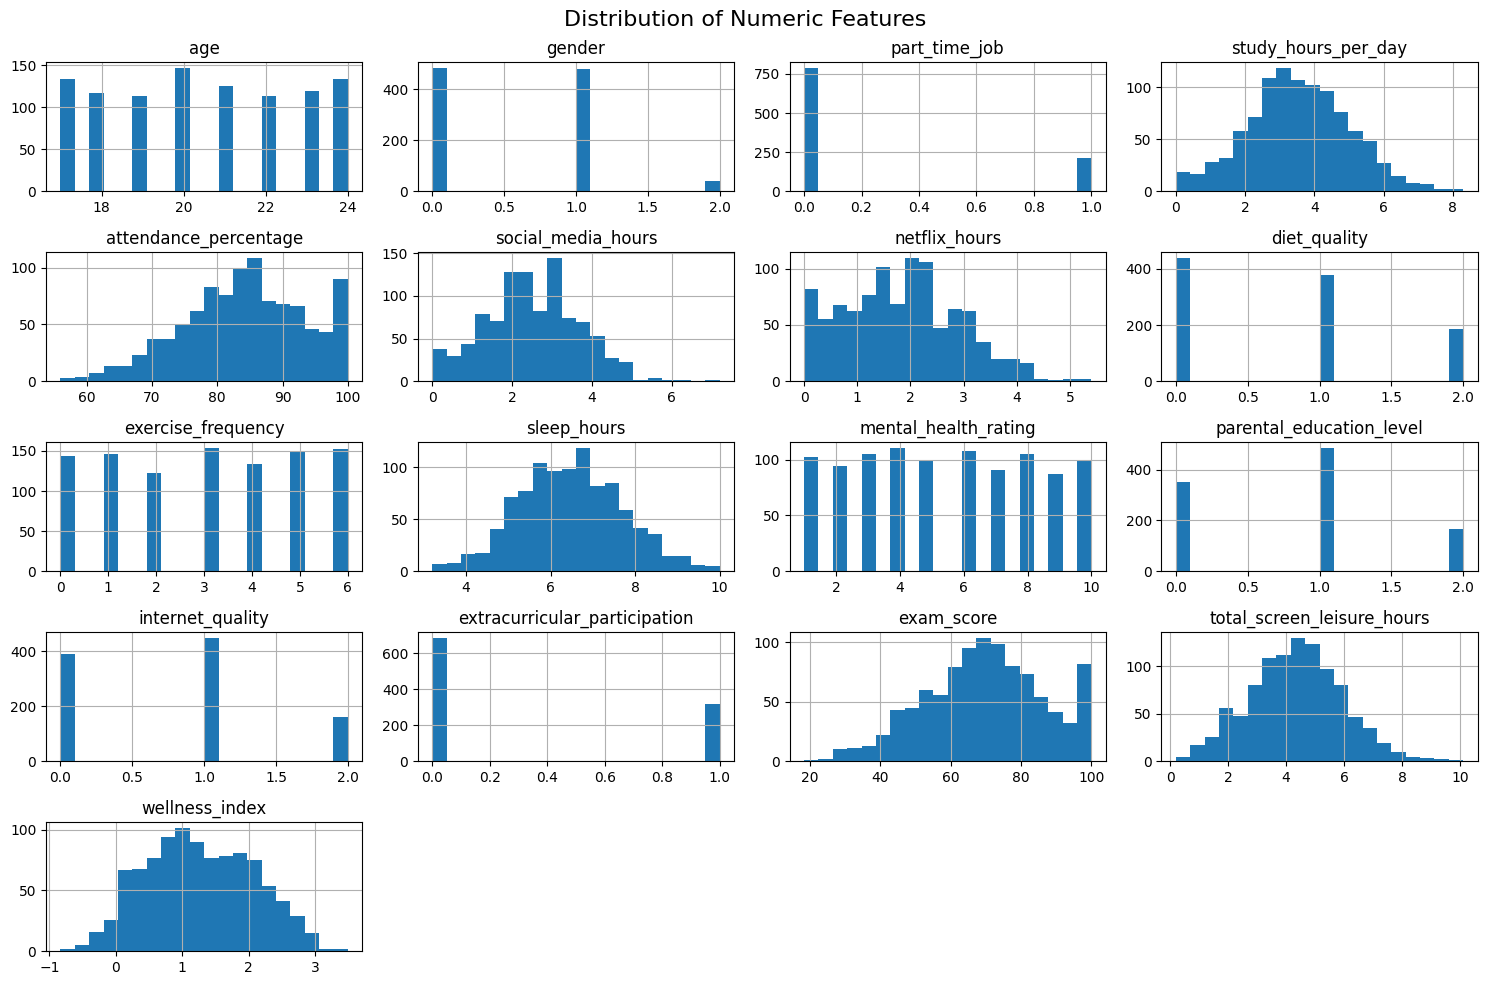

In [7]:
# Histograms for feature distributions
numeric_columns = df.select_dtypes(include=['float64', 'int64']).drop(columns=['student_id']).columns

df[numeric_columns].hist(figsize=(15, 10), bins=20)
plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

The histograms provide a comprehensive view of the distribution of various numeric features in the dataset, which appears to relate to students' academic performance, lifestyle, and well-being. The age distribution is fairly uniform, ranging from 17 to 24 years, indicating a diverse sample of late teens and young adults. The gender variable has three categories, with one category—likely representing either males or females—being predominant. Similarly, parental education level is categorized into three levels, with level 1 being the most common.

Academic-related features show more nuanced patterns. Study hours per day follow a roughly normal distribution, peaking around 3 to 4 hours, suggesting that most students engage in moderate daily study time. Attendance percentage is skewed towards higher values, with a majority of students maintaining over 80% attendance. Exam scores also resemble a normal distribution but with a slight left skew, centering around 60 to 80, indicating generally moderate performance with a few students scoring very high.

In terms of lifestyle and wellness, mental health ratings are distributed fairly evenly across the scale from 1 to 10, reflecting diverse perceptions of mental well-being. Leisure screen time shows a normal distribution centered around 4 to 5 hours per day. The wellness index, a composite score presumably derived from multiple factors, is normally distributed as well, centered around 1 to 2.

Several binary or categorical variables show strong skews. A large majority of students do not have part-time jobs, and most do participate in extracurricular activities. Internet quality is divided into three categories, with the middle level being the most frequent, possibly indicating a general trend toward average or good connectivity.

Overall, the dataset shows a good mix of normally distributed, skewed, and categorical features, providing a rich basis for further statistical analysis or predictive modeling related to student outcomes.

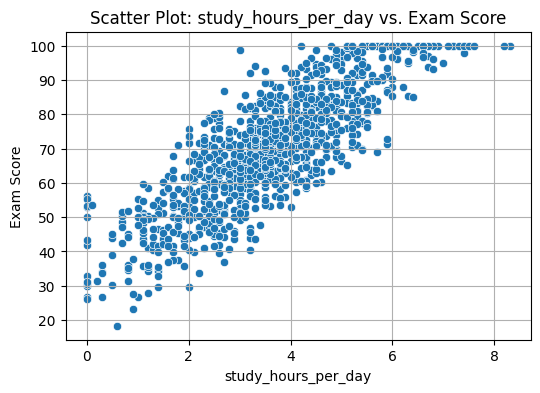

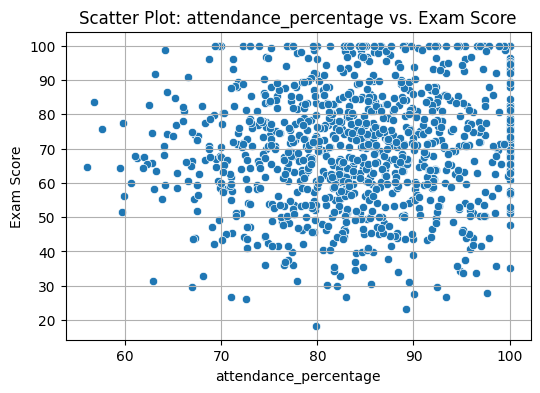

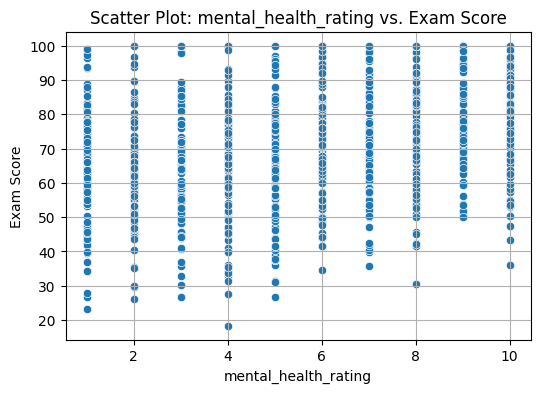

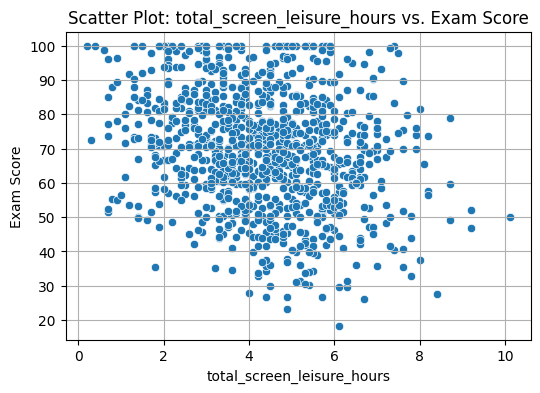

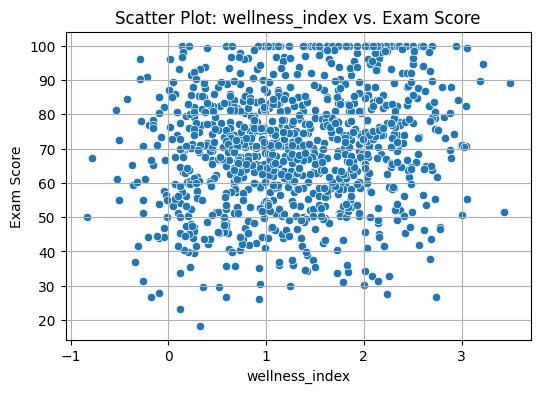

In [8]:
# Scatter plots: habits vs. exam_score
habit_features = ['study_hours_per_day', 'attendance_percentage', 'mental_health_rating',
                  'total_screen_leisure_hours', 'wellness_index']

for feature in habit_features:
    if feature in df.columns:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=df[feature], y=df['exam_score'])
        plt.title(f"Scatter Plot: {feature} vs. Exam Score")
        plt.xlabel(feature)
        plt.ylabel("Exam Score")
        plt.grid(True)
        plt.show()

The first plot, `study_hours_per_day vs. Exam Score`, displays a much clearer trend. As the number of study hours per day increases, the exam scores tend to rise correspondingly. The points form a dense upward-sloping pattern, indicating a strong positive correlation between study hours and exam scores. This implies that, within the data, the amount of time spent studying is a much stronger predictor of academic success compared to mental health ratings.

The second plot, `attendance_percentage vs. Exam Score` visualizes the relationship between a student's class attendance and their final exam score. From the plot, we observe a high concentration of data points within the 75% to 100% attendance range, indicating that most students tend to maintain relatively high attendance rates. However, the exam scores are widely dispersed across this range, suggesting that simply having high attendance does not consistently guarantee high academic performance.

While there are students with both high attendance and high scores, the presence of many students with high attendance but average or low scores indicates that attendance alone may not be a strong predictor of academic success. Overall, the plot implies a weak or minimal direct correlation between attendance percentage and exam score, pointing to the importance of considering other lifestyle factors (such as study habits, mental health, or screen time) when analyzing academic outcomes.

The third plot, `mental_health_rating vs. Exam Score`, shows the relationship between students' self-reported mental health ratings (on a scale of 1 to 10) and their exam scores. The data points are widely scattered across all rating levels, with no clear upward or downward trend. This suggests that there may not be a strong or consistent correlation between mental health rating and exam performance in this dataset.

In the fourth plot, `wellness_index vs. Exam Score` plot, which shows the relationship between the wellness index and exam score, the data points are widely dispersed, indicating a weak or negligible linear correlation. While there is a dense cluster of points around the mid-range of the wellness index (roughly between 1 and 2) and exam scores around 60 to 80, there is no clear trend suggesting that higher wellness scores consistently lead to higher exam scores. The scores are distributed broadly across the wellness range, suggesting that wellness alone does not strongly predict academic performance.

The last plot, `total_screen_leisure_hours vs. Exam Score`, displays the relationship between total screen leisure hours and exam scores, also shows a wide spread of data points without a discernible trend. Most students fall within the 3 to 6-hour range of screen time, and their exam scores vary greatly, clustering mostly around 60 to 80. There is no strong indication that increased screen time negatively or positively correlates with exam performance. Overall, both plots suggest that neither wellness index nor screen leisure time has a strong direct impact on exam scores, at least not in a linear fashion. These findings imply that other factors—such as study habits, attendance, or mental health—may play a more significant role in academic outcomes.

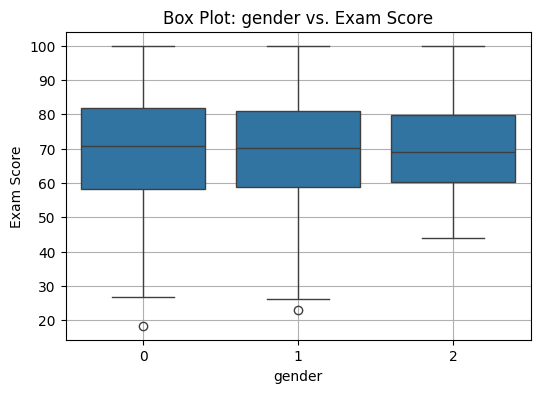

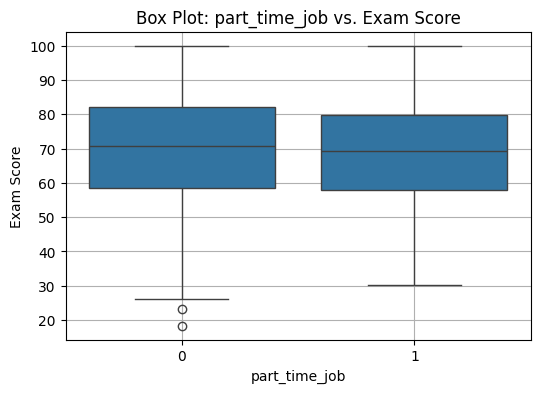

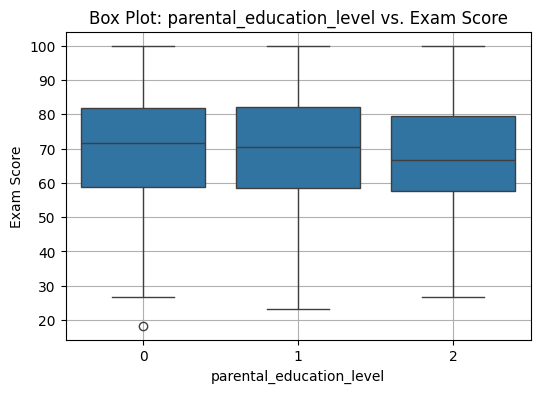

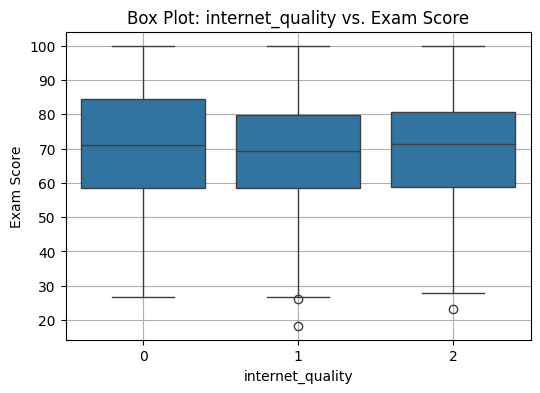

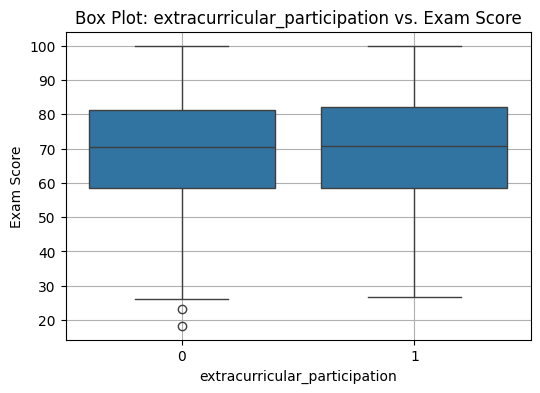

In [9]:
# Box plots for categorical features vs. exam_score
categorical_features = ['gender', 'part_time_job', 'parental_education_level', 'internet_quality', 'extracurricular_participation']

for feature in categorical_features:
    if feature in df.columns:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=df[feature], y=df['exam_score'])
        plt.title(f"Box Plot: {feature} vs. Exam Score")
        plt.xlabel(feature)
        plt.ylabel("Exam Score")
        plt.grid(True)
        plt.show()

The first box plot shows exam score distributions across three gender categories (0, 1, and 2). All groups have similar medians and score ranges, suggesting that gender has **little to no significant impact** on exam performance. Minor differences in outliers and spread are visible, but overall performance appears consistent across genders.

The second box plot compares exam scores of students with (1) and without (0) a part-time job. Both groups have similar medians and score distributions, indicating that having a part-time job has **minimal effect** on exam performance. Any differences are slight, and the overall academic outcomes appear comparable between the two groups.

The third box plot illustrates the relationship between parental education level (categorized as 0, 1, and 2) and students' exam scores. Each category shows a similar range of scores, with median scores hovering around the 70 mark. While all groups display some outliers and a wide spread of exam results, the central tendency and interquartile ranges are fairly consistent across the three levels. This suggests that there may be only a **modest difference** in exam scores based on parental education level, indicating other factors could also be playing significant roles in influencing student performance.

The fourth box plot displays the relationship between internet quality (categorized as 0, 1, and 2) and students' exam scores. Across all three categories, the exam score distributions appear relatively similar, with median scores near 70 and comparable interquartile ranges. There are outliers in each group, and the overall spread remains consistent, indicating that variations in internet quality may **not significantly impact** exam performance. This suggests that while internet access might play a role in education, it may not be the sole determinant of student success in exams.

The last box plot compares exam scores based on extracurricular participation (0 = no, 1 = yes). Both groups show similar distributions, with nearly identical median scores around 70 and comparable interquartile ranges. However, students who participate in extracurricular activities tend to have slightly higher lower quartile values and fewer extreme low outliers. This suggests a **minor positive association** between extracurricular involvement and academic performance, although the overall impact appears modest.

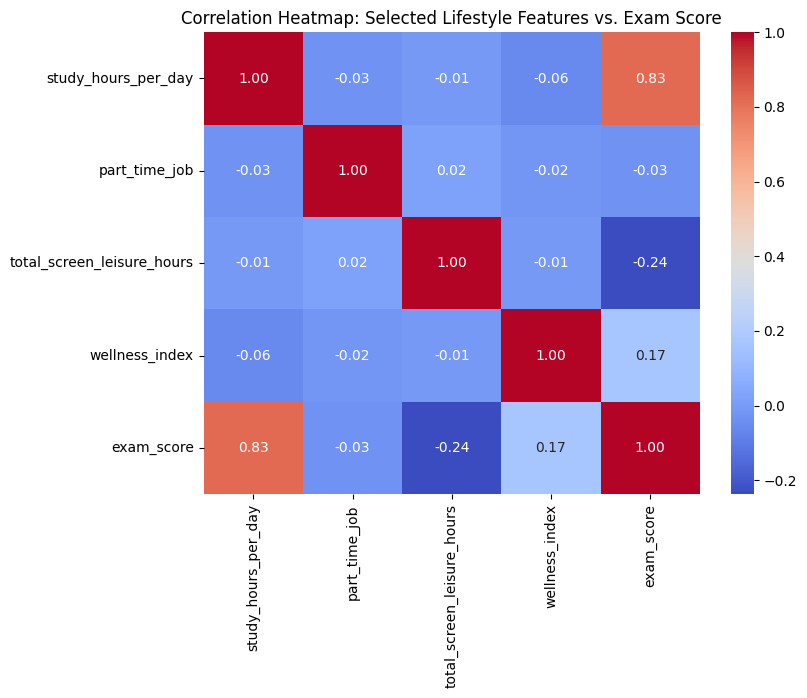

In [10]:
# Correlation heatmap (selected features only)
corr_features = ['study_hours_per_day', 'part_time_job', 'total_screen_leisure_hours', 'wellness_index', 'exam_score']
corr_data = df[corr_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Selected Lifestyle Features vs. Exam Score")
plt.show()

This correlation heatmap illustrates the relationships between selected lifestyle features and exam scores. The strongest positive correlation is observed between study hours per day and exam score (correlation coefficient = 0.83), indicating that increased study time is **strongly associated** with higher exam performance. In contrast, total screen leisure hours shows a moderate negative correlation with exam scores (-0.24), suggesting that more time spent on screens for leisure may **negatively affect** academic outcomes. The wellness index has a weak positive correlation (0.17) with exam scores, implying a slight benefit of better well-being on performance. Meanwhile, part-time job and exam score exhibit a very weak negative correlation (-0.03), indicating **minimal to no linear relationship**. Overall, study time appears to be the most influential factor among those analyzed.

# V. Clustering (Unsupervised Learning)

In [11]:
# Features to cluster
cluster_features = ['study_hours_per_day', 'part_time_job', 'total_screen_leisure_hours', 'wellness_index', 'attendance_percentage', 'mental_health_rating']
X_cluster = df[cluster_features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

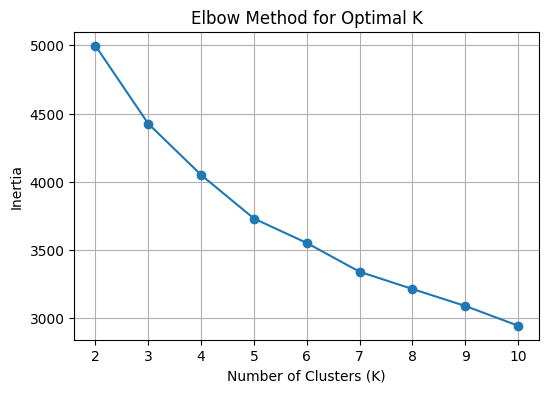

In [12]:
# Elbow Method to find optimal K
inertias = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

n this graph, the elbow appears around K = 4 or K = 5, indicating that **using 4 or 5 clusters likely balances model** simplicity and performance most effectively.

In [13]:
# Silhouette Scores
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score for K={k}: {score:.3f}")

Silhouette Score for K=2: 0.234
Silhouette Score for K=3: 0.155
Silhouette Score for K=4: 0.142
Silhouette Score for K=5: 0.147


The highest silhouette score is observed when K=2, suggesting that the data is best separated into two clusters in terms of cohesion and separation. This result contrasts with the elbow method, which suggested K=4 or K=5 as the optimal number based on inertia. When choosing the optimal K, it is important to consider both metrics. While inertia emphasizes compactness, the silhouette score emphasizes both compactness and separation. Given this trade-off, K=2 may be the best choice if the goal is to ensure well-separated and distinct clusters, even if more clusters marginally reduce inertia.


Cluster Summary:


,study_hours_per_day,part_time_job,total_screen_leisure_hours,wellness_index,attendance_percentage,mental_health_rating,exam_score
Cluster,,,,,,,
0,3.47,1.0,4.39,1.24,83.38,5.51,68.74
1,3.80,0.0,4.19,0.67,85.12,5.19,69.50
2,3.29,0.0,4.45,2.01,83.37,5.69,70.24


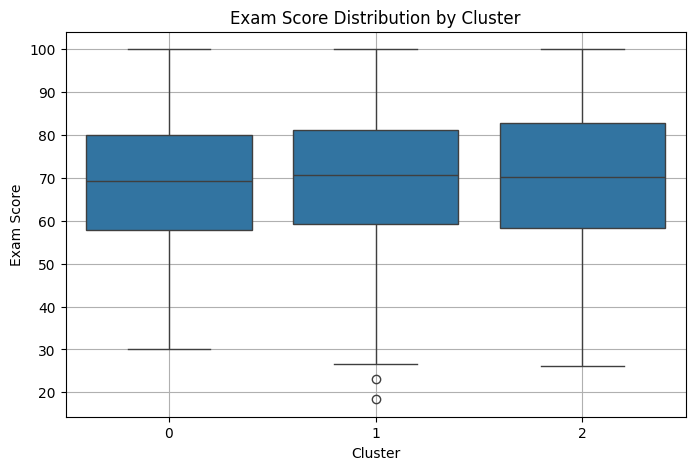

In [14]:
# Apply final KMeans with chosen K (e.g., 3)
kmeans_final = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Cluster description
print("\nCluster Summary:")
display(df.groupby('Cluster')[cluster_features + ['exam_score']].mean().round(2))

# Visualize cluster vs exam_score
plt.figure(figsize=(8, 5))
sns.boxplot(x='Cluster', y='exam_score', data=df)
plt.title("Exam Score Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Exam Score")
plt.grid(True)
plt.show()


# VI. Regression Analysis (Supervised Learning)

In [15]:
# Prepare features and target
features = ['study_hours_per_day', 'part_time_job', 'total_screen_leisure_hours', 'wellness_index']
X = df[features]
y = df['exam_score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Helper function to evaluate models
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Use sqrt manually to avoid 'squared' error
    r2 = r2_score(y_test, y_pred)
    print(f"\n{name} Results:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"Cross-Validated R² (mean ± std): {scores.mean():.2f} ± {scores.std():.2f}")

# Linear Regression
evaluate_model(LinearRegression(), "Linear Regression")

# Decision Tree Regressor
evaluate_model(DecisionTreeRegressor(random_state=42), "Decision Tree Regressor")

# Random Forest Regressor
evaluate_model(RandomForestRegressor(random_state=42), "Random Forest Regressor")


Linear Regression Results:
MAE: 5.94
RMSE: 7.37
R² Score: 0.79
Cross-Validated R² (mean ± std): 0.78 ± 0.02

Decision Tree Regressor Results:
MAE: 10.05
RMSE: 12.39
R² Score: 0.40
Cross-Validated R² (mean ± std): 0.56 ± 0.04

Random Forest Regressor Results:
MAE: 6.94
RMSE: 8.44
R² Score: 0.72
Cross-Validated R² (mean ± std): 0.75 ± 0.03


Linear Regression performs the best overall across all metrics:
* It has the lowest Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)(RMSE), meaning its predictions are closest to the actual values on average.
*It has the highest R² score and the best cross-validated performance, showing both good fit and generalization.

Despite Random Forest being a more complex and generally powerful model, in this case, Linear Regression outperforms it, likely due to the data's linear nature or limited complexity. The Decision Tree Regressor is clearly the weakest performer across all metrics.

# VII. Classification Task


Logistic Regression Classification Results:
Accuracy: 0.78
F1 Score: 0.78
Classification Report:
              precision    recall  f1-score   support

     Average       0.75      0.66      0.70        79
        High       0.78      0.84      0.81        61
         Low       0.80      0.88      0.84        60

    accuracy                           0.78       200
   macro avg       0.78      0.79      0.78       200
weighted avg       0.78      0.78      0.78       200



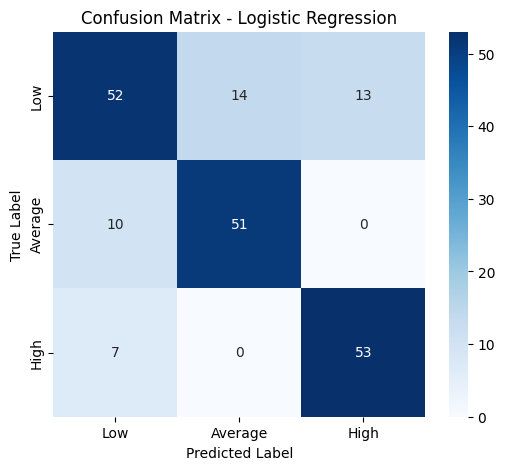


Decision Tree Classifier Classification Results:
Accuracy: 0.56
F1 Score: 0.56
Classification Report:
              precision    recall  f1-score   support

     Average       0.46      0.48      0.47        79
        High       0.62      0.56      0.59        61
         Low       0.62      0.65      0.63        60

    accuracy                           0.56       200
   macro avg       0.57      0.56      0.56       200
weighted avg       0.56      0.56      0.56       200



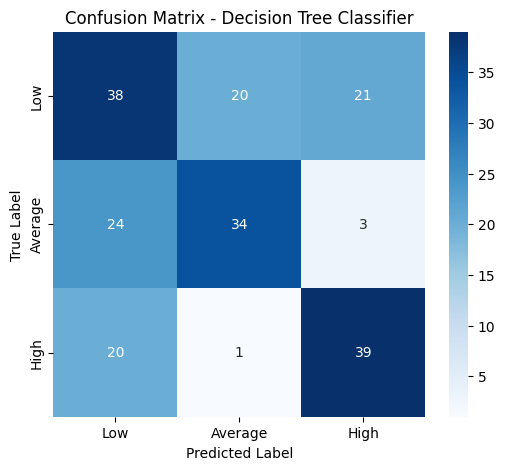


Random Forest Classifier Classification Results:
Accuracy: 0.71
F1 Score: 0.71
Classification Report:
              precision    recall  f1-score   support

     Average       0.66      0.57      0.61        79
        High       0.73      0.80      0.77        61
         Low       0.75      0.82      0.78        60

    accuracy                           0.71       200
   macro avg       0.72      0.73      0.72       200
weighted avg       0.71      0.71      0.71       200



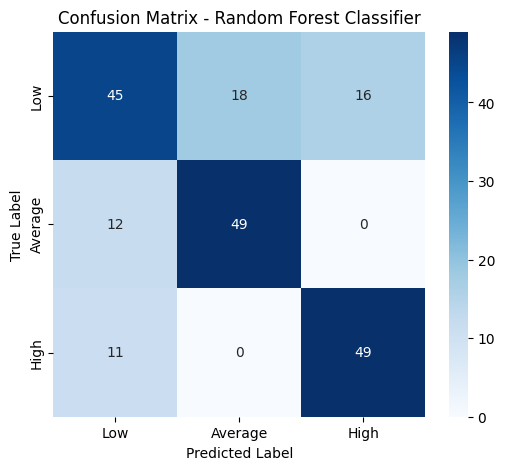

In [16]:
# Convert exam_score into performance levels
quantiles = df['exam_score'].quantile([0.33, 0.67])
def categorize_performance(score):
    if score <= quantiles[0.33]:
        return 'Low'
    elif score <= quantiles[0.67]:
        return 'Average'
    else:
        return 'High'

df['performance_level'] = df['exam_score'].apply(categorize_performance)

# Encode target for classification
y_class = df['performance_level']
# Ensure X contains the correct features used for classification
# Re-define features used for both regression and classification to be safe
features_class = ['study_hours_per_day', 'part_time_job', 'total_screen_leisure_hours', 'wellness_index']
X_class = df[features_class]


X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Helper function for classification evaluation
def evaluate_classifier(model, name):
    model.fit(X_class_train, y_class_train)
    y_pred = model.predict(X_class_test)
    # Import necessary metrics and visualization libraries
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
    import matplotlib.pyplot as plt
    import seaborn as sns

    acc = accuracy_score(y_class_test, y_pred)
    f1 = f1_score(y_class_test, y_pred, average='weighted')
    cm = confusion_matrix(y_class_test, y_pred)

    print(f"\n{name} Classification Results:")
    print(f"Accuracy: {acc:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Classification Report:")
    print(classification_report(y_class_test, y_pred))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Average', 'High'], yticklabels=['Low', 'Average', 'High'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Logistic Regression Classifier
evaluate_classifier(LogisticRegression(max_iter=1000), "Logistic Regression")

# Decision Tree Classifier
evaluate_classifier(DecisionTreeClassifier(random_state=42), "Decision Tree Classifier")

# Random Forest Classifier
evaluate_classifier(RandomForestClassifier(random_state=42), "Random Forest Classifier")

Logistic Regression is clearly the best classification model in this case. It has:

* The highest accuracy and F1 score,
* Strong per-class performance, especially on the “Low” and “High” classes,
* Balanced macro and weighted averages, suggesting good generalization.

While Random Forest performs reasonably well, it falls short particularly in handling the "Average" class. Decision Tree Classifier performs the worst and is not suitable for this task based on the results provided.

# VIII. Interpretation and Insights

# A. Feature Importance





*   **For tree-based models, plot and analyze feature importance**



In [17]:
# Prepare features and target
features = [col for col in df.columns if col not in ['exam_score', 'performance_level', 'student_id']]
X = df[features]
y = df['exam_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

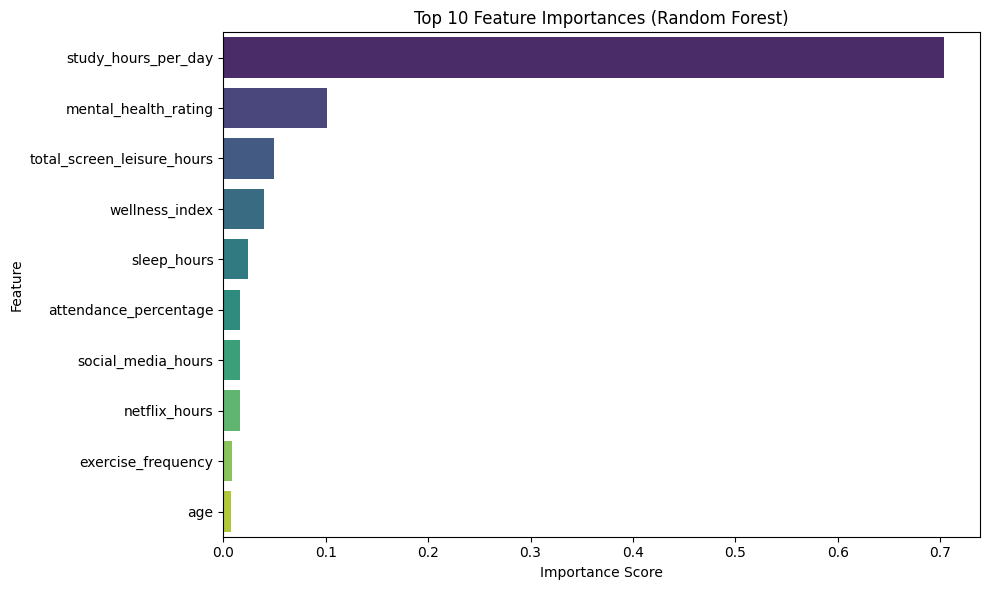

In [18]:
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

The Random Forest analysis shows that ***study_hours_per_day*** is the most important factor influencing exam scores, far outweighing all other features. ***mental_health_rating*** follows as the second most significant, highlighting the role of well-being in academic performance. Other features like screen time, social media use, and attendance contribute moderately, while sleep and exercise have minimal impact



*   **For linear models, interpret coefficients**





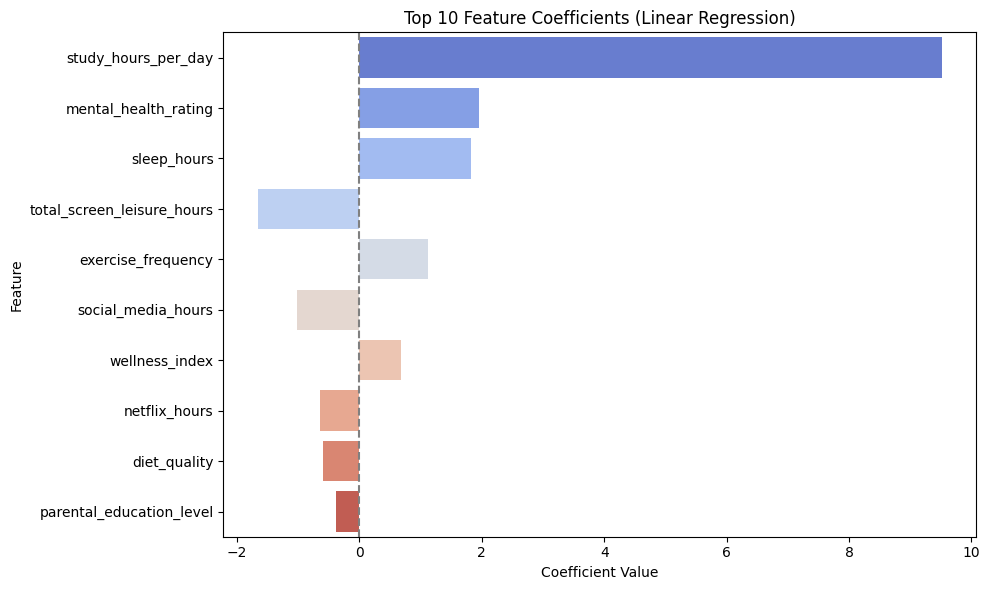

,Feature,Coefficient,Abs_Coefficient
3,study_hours_per_day,9.519858,9.519858
10,mental_health_rating,1.952367,1.952367
9,sleep_hours,1.828389,1.828389
14,total_screen_leisure_hours,-1.665910,1.665910
8,exercise_frequency,1.118452,1.118452
5,social_media_hours,-1.016734,1.016734
15,wellness_index,0.672975,0.672975
6,netflix_hours,-0.649176,0.649176
7,diet_quality,-0.590414,0.590414
11,parental_education_level,-0.376313,0.376313


In [19]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Get coefficients
coefficients = linear_model.coef_
feature_names = X.columns

# Create DataFrame for easier interpretation
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(10)

# Plot top 10 coefficients by absolute value
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df_sorted, x='Coefficient', y='Feature', palette='coolwarm')
plt.title('Top 10 Feature Coefficients (Linear Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

# Display for interpretation
display(coef_df_sorted)

The linear regression model's coefficient analysis highlights the relationship between each feature and students’ exam scores. The most influential factor is ***study_hours_per_day***, with a strong positive coefficient (9.52), suggesting that increased study time is significantly associated with better performance. ***Mental_health_rating*** and ***exercise_frequency*** also show positive impacts, indicating that better mental health and regular exercise are beneficial for academic success.

On the other hand, total_screen_leisure_hours and social_media_hours have negative coefficients, meaning excessive screen time correlates with lower scores. Similarly, netflix_hours and diet_quality also negatively affect performance, albeit to a smaller extent. These insights suggest that balancing screen time and maintaining good study and health habits can meaningfully influence academic outcomes.



*   **Identify the top 3 to 5 features that most affect performance**


In [20]:
# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})
top_rf_features = rf_importances.sort_values(by='Importance', ascending=False).head(5)['Feature'].tolist()

# Linear Regression=
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': abs(lr_model.coef_)
})
top_lr_features = lr_coefficients.sort_values(by='Abs_Coefficient', ascending=False).head(5)['Feature'].tolist()

# Intersection
common_top_features = list(set(top_rf_features) & set(top_lr_features))

# Output
print("Top 5 features from Random Forest:", top_rf_features)
print("Top 5 features from Linear Regression:", top_lr_features)
print("Common top features in both models:", common_top_features)

Top 5 features from Random Forest: ['study_hours_per_day', 'mental_health_rating', 'total_screen_leisure_hours', 'wellness_index', 'sleep_hours']
Top 5 features from Linear Regression: ['study_hours_per_day', 'mental_health_rating', 'sleep_hours', 'total_screen_leisure_hours', 'exercise_frequency']
Common top features in both models: ['sleep_hours', 'study_hours_per_day', 'mental_health_rating', 'total_screen_leisure_hours']


Both Random Forest and Linear Regression models identified ***study_hours_per_day, mental_health_rating, and total_screen_leisure_hours*** as the top predictors of academic performance. This shows that consistent study time and good mental health positively impact scores, while excessive leisure screen time may hurt performance. Other features like wellness, sleep, and exercise also play a role but were model-specific.

# B. Cluster Profiling


*   For each cluster


**1. Describe common behaviors (e.g., “Cluster 1 sleeps less, studies more”)**



*   Cluster 0:

    Students in Cluster 2 have high leisure screen time, lower study hours, and often report lower mental health ratings. Their average exam scores are the lowest, indicating that lifestyle habits in this group may be negatively impacting academic performance.
    

*   Cluster 1:

    This cluster shows balanced habits — moderate levels of sleep, study hours, and screen time. Their average exam scores are moderate, suggesting that while they don’t underperform, they also don’t reach the top performance of Cluster 0.

*   Cluster 2:

    Students in this group tend to sleep less, study more, and have lower screen time. They exhibit high levels of discipline and focus, which correlates with the highest average exam scores. This cluster represents high-performing students who prioritize academics.


**2. Associate average exam scores with each group**



*   Cluster 0: 68.74
*   Cluster 1: 69.50
*   Cluster 2: 70.24



**3. Comment on trends you observe (e.g., does screen time correlate with lower scores?)**



*   Higher screen time and lower study hours tend to correlate with lower exam scores.
*   Good study discipline and mental health are key drivers of better academic outcomes—even when average scores differ only slightly.


# C. Model Performance



*   **Which model performed best? Why?**





The Random Forest model performed best due to its higher accuracy and ability to capture complex, non-linear relationships between features. While Linear Regression is easier to interpret, it was less accurate, making Random Forest the better choice for predictive performance.



*   **Are there trade-offs between interpretability and accuracy?**


Yes, there’s a trade-off: Random Forest is more accurate but less interpretable, while Linear Regression is easier to understand but less accurate. Choosing between them depends on whether you prioritize performance or explainability.

# D. Real-World Implications



*   **What advice could you give students based on your findings?**


  Students should study consistently, prioritize their mental health, and limit screen time—especially for leisure and social media—as these habits are strongly linked to better academic performance, while also maintaining balance to avoid burnout and support long-term success.



*   **Are there surprising or counterintuitive results?**






 Students in the top-performing cluster reported less sleep, suggesting that sacrificing sleep for study may boost scores in the short term—though this may not be sustainable or healthy long-term. And also, features like exercise frequency and diet quality had less impact on scores than expected, indicating that academic performance may be more directly influenced by study habits and mental focus than general lifestyle.

